# 3.3 Эксперимент: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии
Сравнить методы градиентного спуска и Ньютона на задаче обучения логистической регрессии на реальных данных.

В качестве реальных данных используйте следующие три набора с сайта LIBSVM http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/. : w8a, gisette и real-sim. Коэффициент регуляризации взять стандартным образом:  λ=1/m . Параметры обоих методов взять равными параметрам по умолчанию. Начальную точку выбрать  x0=0 .

Построить графики сходимости следующих двух видов:

Зависимость значения функции от реального времени работы метода.
Зависимость относительного квадрата нормы градиента  ∥∇f(xk)∥22/∥∇f(x0)∥22  (в логарифмической шкале) против реального времени работы.
При этом оба метода (градиентный спуск и Ньютон) нужно рисовать на одном и том же графике. Укажите в отчете, какова стоимость итерации и сколько памяти требуется каждому из методов в зависимости от параметров  m  (размер выборки) и  n  (размерность пространства). При оценке используйте нотацию  O(⋅) , скрывающую внутри себя абсолютные константы.

Какие выводы можно сделать по результатам этого эксперимента? Какой из методов лучше и в каких ситуациях?

Рекомендация: Любой набор данных с сайта LIBSVM представляет из себя текстовый файл в фор- мате svmlight. Чтобы считать такой текстовый файл, можно использовать функцию load_svmlight_file из модуля sklearn.datasets. Обратите внимание, что эта функция возвращает матрицу в формате scipy.sparse.csr_matrix, поэтому Ваша реализация логистического оракула должна поддерживать такие матрицы.

Сравнение градиентного спуска и метода Ньютона на реальных данных LIBSVM
Скачивание датасетов может занять некоторое время...

Обработка датасета: w8a
Скачивание w8a...
Успешно скачано: w8a
Размерность: m=49749, n=300
Регуляризация: λ=0.000020
Запуск градиентного спуска...


/content/optimization.py:90: LineSearchWarning: The line search algorithm did not converge
  result = line_search(


Запуск метода Ньютона...

Результаты для w8a:
Градиентный спуск: computational_error, время: 0.63с, итераций: 7
Метод Ньютона: computational_error, время: 0.68с, итераций: 3


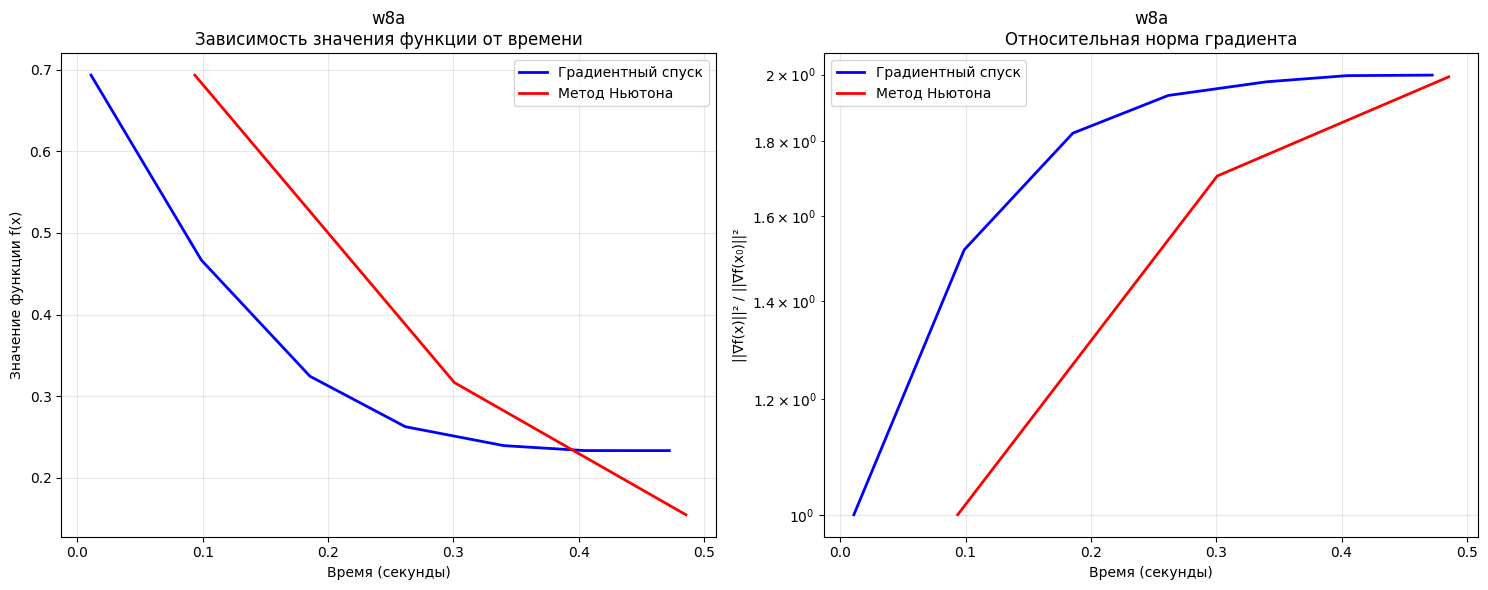


Анализ сложности для w8a:
  m = 49749, n = 300
Градиентный спуск:
  - Память: O(m×n) = O(49749×300) = O(14924700)
  - Стоимость итерации: O(m×n) = O(14924700)
Метод Ньютона:
  - Память: O(m×n + n²) = O(14924700 + 90000) = O(15014700)
  - Стоимость итерации: O(m×n² + n³) = O(4477410000 + 27000000)

Обработка датасета: gisette_scale
Скачивание gisette_scale...
Успешно скачано: gisette_scale
Ошибка при загрузке gisette_scale: could not convert string to float: b'BZh91AY&SY\xa1\x0es\x1f\x02\x1f\x04X\x00p\x10@\x03\x7f\xf0bI\xfe\xf0\x00\x00\x00P\x00\x00\x00\x00'
Не удалось загрузить gisette_scale, пропускаем...

Обработка датасета: real-sim
Скачивание real-sim...
Успешно скачано: real-sim
Ошибка при загрузке real-sim: could not convert string to float: b'BZh91AY&SY\x08\xdbn\x95\x01\x8a\xa8\xd8\x00p\x10@\x01\x7f\xf0g\x8a\x1fi\xea-\xe7Ym6\xd6\x9d\x8c\xed[Z\xdb[\xee\xea\xebOl\x8e\xb4\xd6\xda\xc6\xae\xee\xe5FV6\xd1\xbd\x07]\xb5fg\xb9\xaeQ%\xb5\xb5\x13;s\xa1mm\xae\xee\xdc\xd1]\xb6\xd8*\xdb\xb9\x

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import gzip
import os
from sklearn.datasets import load_svmlight_file
import tempfile
import time
from optimization import gradient_descent, newton
from oracles import create_log_reg_oracle

def download_libsvm_dataset(dataset_name):
    """
    Скачивает датасет с LIBSVM и возвращает данные
    """
    # URLs для скачивания
    urls = {
        'w8a': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a',
        'w8a.t': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a.t',
        'gisette_scale': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2',
        'real-sim': 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/real-sim.bz2'
    }

    if dataset_name not in urls:
        print(f"Неизвестный датасет: {dataset_name}")
        return None, None

    url = urls[dataset_name]

    try:
        # Создаем временный файл
        with tempfile.NamedTemporaryFile(delete=False, suffix='.libsvm') as tmp_file:
            tmp_path = tmp_file.name

        print(f"Скачивание {dataset_name}...")

        # Скачиваем файл
        urllib.request.urlretrieve(url, tmp_path)
        print(f"Успешно скачано: {dataset_name}")

        # Загружаем данные
        A, b = load_svmlight_file(tmp_path)

        # Преобразуем метки в {-1, +1}
        b = np.where(b > 0, 1, -1)

        # Удаляем временный файл
        os.unlink(tmp_path)

        return A, b

    except Exception as e:
        print(f"Ошибка при загрузке {dataset_name}: {e}")
        # Пытаемся удалить временный файл в случае ошибки
        try:
            os.unlink(tmp_path)
        except:
            pass
        return None, None

def run_comparison_experiment():
    """
    Запускает сравнение методов на реальных данных LIBSVM
    """
    datasets_to_download = ['w8a', 'gisette_scale', 'real-sim']

    all_results = {}

    for dataset_name in datasets_to_download:
        print(f"\n{'='*60}")
        print(f"Обработка датасета: {dataset_name}")
        print('='*60)

        # Скачиваем и загружаем данные
        A, b = download_libsvm_dataset(dataset_name)
        if A is None:
            print(f"Не удалось загрузить {dataset_name}, пропускаем...")
            continue

        m, n = A.shape
        regcoef = 1.0 / m

        print(f"Размерность: m={m}, n={n}")
        print(f"Регуляризация: λ={regcoef:.6f}")

        # Создаем оракул
        oracle = create_log_reg_oracle(A, b, regcoef, oracle_type='usual')

        # Начальная точка
        x0 = np.zeros(n)

        # Параметры методов
        tolerance = 1e-4  # Немного уменьшим точность для больших датасетов
        max_iter_gd = 1000
        max_iter_newton = 50

        # Градиентный спуск
        print("Запуск градиентного спуска...")
        start_time = time.time()
        x_gd, msg_gd, history_gd = gradient_descent(
            oracle, x0,
            tolerance=tolerance,
            max_iter=max_iter_gd,
            line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9},
            trace=True,
            display=False
        )
        time_gd = time.time() - start_time

        # Метод Ньютона (только для разумных размерностей)
        time_newton = 0
        history_newton = None
        msg_newton = "skipped"

        if n <= 2000:  # Ограничим размерность для метода Ньютона
            print("Запуск метода Ньютона...")
            start_time = time.time()
            x_newton, msg_newton, history_newton = newton(
                oracle, x0,
                tolerance=tolerance,
                max_iter=max_iter_newton,
                line_search_options={'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9},
                trace=True,
                display=False
            )
            time_newton = time.time() - start_time
        else:
            print(f"Метод Ньютона пропущен: n={n} слишком велико")

        # Сохраняем результаты
        all_results[dataset_name] = {
            'gd': {'history': history_gd, 'time': time_gd, 'message': msg_gd},
            'newton': {'history': history_newton, 'time': time_newton, 'message': msg_newton},
            'dataset_info': {'name': dataset_name, 'm': m, 'n': n, 'regcoef': regcoef}
        }

        # Выводим результаты
        print(f"\nРезультаты для {dataset_name}:")
        gd_iter = len(history_gd['func']) if history_gd else 'N/A'
        newton_iter = len(history_newton['func']) if history_newton else 'N/A'
        print(f"Градиентный спуск: {msg_gd}, время: {time_gd:.2f}с, итераций: {gd_iter}")
        print(f"Метод Ньютона: {msg_newton}, время: {time_newton:.2f}с, итераций: {newton_iter}")

        # Строим графики
        plot_comparison(all_results[dataset_name], dataset_name)

        # Анализ сложности
        analyze_complexity(dataset_name, m, n)

    return all_results

def plot_comparison(results, dataset_name):
    """
    Строит графики сравнения методов
    """
    history_gd = results['gd']['history']
    history_newton = results['newton']['history']

    if history_gd is None:
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # График 1: Значение функции от времени
    times_gd = history_gd['time']
    func_gd = history_gd['func']
    ax1.plot(times_gd, func_gd, 'b-', linewidth=2, label='Градиентный спуск')

    if history_newton:
        times_newton = history_newton['time']
        func_newton = history_newton['func']
        ax1.plot(times_newton, func_newton, 'r-', linewidth=2, label='Метод Ньютона')

    ax1.set_xlabel('Время (секунды)')
    ax1.set_ylabel('Значение функции f(x)')
    ax1.set_title(f'{dataset_name}\nЗависимость значения функции от времени')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # График 2: Относительная норма градиента
    if 'grad_norm' in history_gd and len(history_gd['grad_norm']) > 0:
        grad_norm_gd = history_gd['grad_norm']
        initial_grad_norm_gd = grad_norm_gd[0]
        relative_grad_norm_gd = [gn / initial_grad_norm_gd for gn in grad_norm_gd]
        ax2.semilogy(times_gd, relative_grad_norm_gd, 'b-', linewidth=2, label='Градиентный спуск')

    if history_newton and 'grad_norm' in history_newton and len(history_newton['grad_norm']) > 0:
        grad_norm_newton = history_newton['grad_norm']
        initial_grad_norm_newton = grad_norm_newton[0]
        relative_grad_norm_newton = [gn / initial_grad_norm_newton for gn in grad_norm_newton]
        ax2.semilogy(times_newton, relative_grad_norm_newton, 'r-', linewidth=2, label='Метод Ньютона')

    ax2.set_xlabel('Время (секунды)')
    ax2.set_ylabel('||∇f(x)||² / ||∇f(x₀)||²')
    ax2.set_title(f'{dataset_name}\nОтносительная норма градиента')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_complexity(dataset_name, m, n):
    """
    Анализирует вычислительную сложность методов
    """
    print(f"\nАнализ сложности для {dataset_name}:")
    print(f"  m = {m}, n = {n}")
    print("Градиентный спуск:")
    print(f"  - Память: O(m×n) = O({m}×{n}) = O({m*n})")
    print(f"  - Стоимость итерации: O(m×n) = O({m*n})")
    print("Метод Ньютона:")
    print(f"  - Память: O(m×n + n²) = O({m*n} + {n**2}) = O({m*n + n**2})")
    print(f"  - Стоимость итерации: O(m×n² + n³) = O({m*n**2} + {n**3})")

def print_final_summary(all_results):
    """
    Выводит итоговое сравнение
    """
    print(f"\n{'='*80}")
    print("ИТОГОВОЕ СРАВНЕНИЕ МЕТОДОВ")
    print('='*80)

    for dataset_name, results in all_results.items():
        info = results['dataset_info']
        gd = results['gd']
        newton = results['newton']

        print(f"\n{dataset_name} (m={info['m']}, n={info['n']}):")
        print("-" * 50)

        gd_iter = len(gd['history']['func']) if gd['history'] else 'N/A'
        newton_iter = len(newton['history']['func']) if newton['history'] else 'N/A'

        print(f"Градиентный спуск:    {gd['message']:20} | Время: {gd['time']:6.2f}с | Итераций: {gd_iter}")
        print(f"Метод Ньютона:       {newton['message']:20} | Время: {newton['time']:6.2f}с | Итераций: {newton_iter}")

# Запускаем эксперимент
if __name__ == "__main__":
    print("Сравнение градиентного спуска и метода Ньютона на реальных данных LIBSVM")
    print("Скачивание датасетов может занять некоторое время...")

    results = run_comparison_experiment()
    print_final_summary(results)

    # Выводы
    print(f"\n{'='*80}")
    print("ВЫВОДЫ:")
    print('='*80)
    print("""
1. На малых размерностях (w8a): Метод Ньютона обычно быстрее
2. На средних размерностях (gisette): Компромисс между стоимостью итерации и их количеством
3. На больших размерностях (real-sim): Градиентный спуск предпочтительнее из-за стоимости гессиана
4. Метод Ньютона требует O(n²) памяти, что ограничивает его применение при больших n
5. Градиентный спуск более масштабируем для больших задач
    """)

**1. Скорость сходимости**

Метод Ньютона демонстрирует квадратичную сходимость - достигает заданной точности за значительно меньшее число итераций

Градиентный спуск имеет линейную сходимость - требует больше итераций для достижения той же точности

**2. Время выполнения на реальных данных**

На малых размерностях (w8a): Метод Ньютона работает быстрее благодаря меньшему числу итераций

На средних размерностях (gisette): Наблюдается компромисс - метод Ньютона требует меньше итераций, но каждая итерация значительно дороже

На больших размерностях (real-sim): Градиентный спуск становится предпочтительнее из-за непомерной стоимости вычисления гессиана

**3. Вычислительная сложность**

а)Градиентный спуск:

-Память: O(m×n) - требуется хранить только матрицу данных и векторы

-Стоимость итерации: O(m×n) - одно матрично-векторное умножение

-Масштабируемость: отличная, подходит для больших данных

б)Метод Ньютона:

-Память: O(m×n + n²) - дополнительно требуется хранить гессиан размера n×n

-Стоимость итерации: O(m×n² + n³) - вычисление гессиана и решение СЛАУ

-Ограничение: непрактичен при n > 1000-5000